In [7]:
from functools import partial

import pandas as pd
import src.utils as utils
import src.content as content

In [8]:
metrics = utils.load_all_metric_files()

In [9]:
# This automatically picks the latest month in the data as the reporting period but you
# can replace the line to manually specify any month you choose.
# For example: `month_to_report = pd.Period("2023-06", freq="M")`

month_to_report = metrics.index[-1]
calculate_report = partial(utils.calc_rpt, reporting_period=month_to_report)
format_report = partial(utils.format_report, reporting_period=month_to_report)

## Essential metrics report

In [10]:
essential_metrics = [
    "interactions",
    "unique_devices",
    "northern_western_europe_unique_devices",
    "north_america_unique_devices",
    "east_southeast_asia_pacific_unique_devices",
    "central_eastern_europe_central_asia_unique_devices",
    "latin_america_caribbean_unique_devices",
    "middle_east_north_africa_unique_devices",
    "south_asia_unique_devices",
    "subsaharan_africa_unique_devices",
    "active_editors",
    "returning_active_editors",
    "new_active_editors",
    "net_new_Wikipedia_articles",
    "net_new_Commons_content_pages",
    "net_new_Wikidata_entities",
]

(
    metrics
    .reindex(essential_metrics, axis="columns")
    .apply(calculate_report)
    .transpose()
    .pipe(format_report, metrics_type="essential")

)

## Core annual plan metrics report

In [11]:
core_metrics = [
    # % new quality biography articles about women and gender-diverse people
    # % new quality articles about regions that are underrepresented
    "unique_devices",
    "south_asia_unique_devices",
    "latin_america_caribbean_unique_devices",
    "north_america_unique_devices",
    "northern_western_europe_unique_devices"
]

(
    metrics
    .reindex(core_metrics, axis="columns")
    .apply(calculate_report)
    .transpose()
    .pipe(format_report, metrics_type="core")
)

# Content Metrics

In [12]:
#     """
#    The monthly metrics for the content gap data is calculated as the Month over Month change in new articles. for each category in
#    the regional/gender data, as a proportion of new articles. The naive forecast is calculated as the rate of change
#    from the same month last year to the subsequent month multiplied by the current month's proportion.
   
#     """


minorities = [
    "underrepresented_regions_sum",
    "female + gender_diverse"
]

totals = [
    "all_regions_sum", 
    "all_genders_sum"
]

index_names = [
    "% new quality articles about regions that are underrepresented", 
    "% new quality biography articles about women and gender-diverse people"
]

# Check if any value in the 'minorities' or 'totals' columns for the 'month_to_report' row is NaN and remove that month.
# Content metrics gap data is released a few weeks after the rest of the metrics data is released.
# This is because prior cleaning of the data removes the latest month since it will only contain partial data for that month.


if metrics.loc[month_to_report, minorities + totals].isna().any():
    month_to_report = metrics.index[-2]

(
    metrics
    .pipe(content.calc_content_rpt, month_to_report, minorities, totals, index_names)
    .transpose()
    .pipe(format_report, metrics_type="content gap metrics", reporting_period=month_to_report)
)

## Core annual plan and essential metric charts

Changing directory to:/srv/home/hghani/movement-metrics/wikicharts
Generating Content Interactions chart...



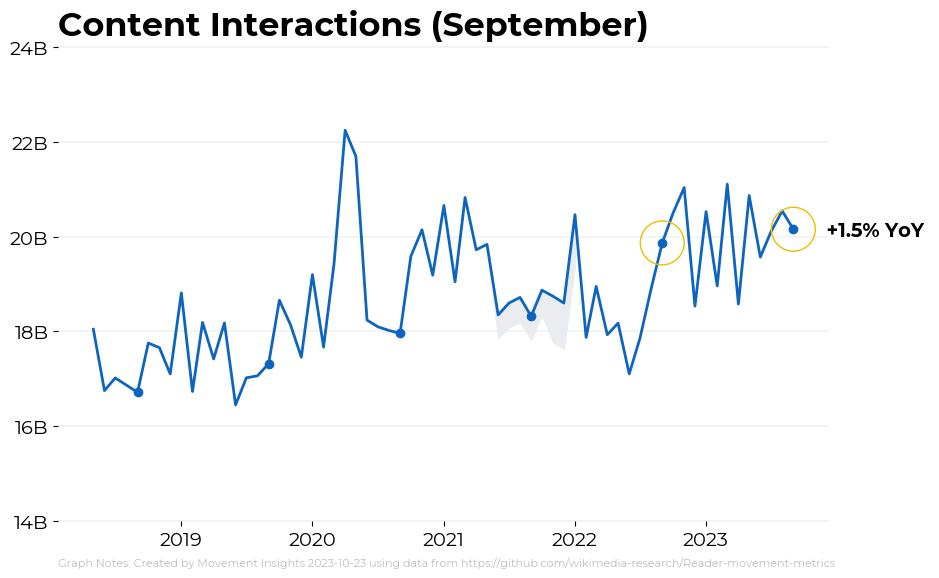

Generating Unique Devices chart...
Formatting may look incorrect in jupyter notebook window but the saved chart image will still be correct.


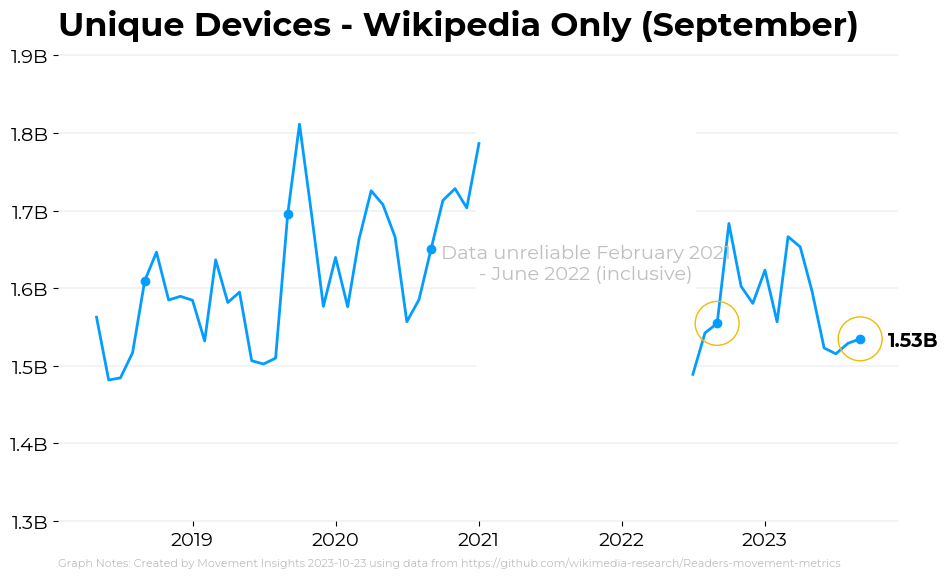

Generating Regional Unique Devices chart...
Formatting may look incorrect in jupyter notebook window but the saved chart image will still be correct.
 
 
 
 
 
 
 
 
 
 


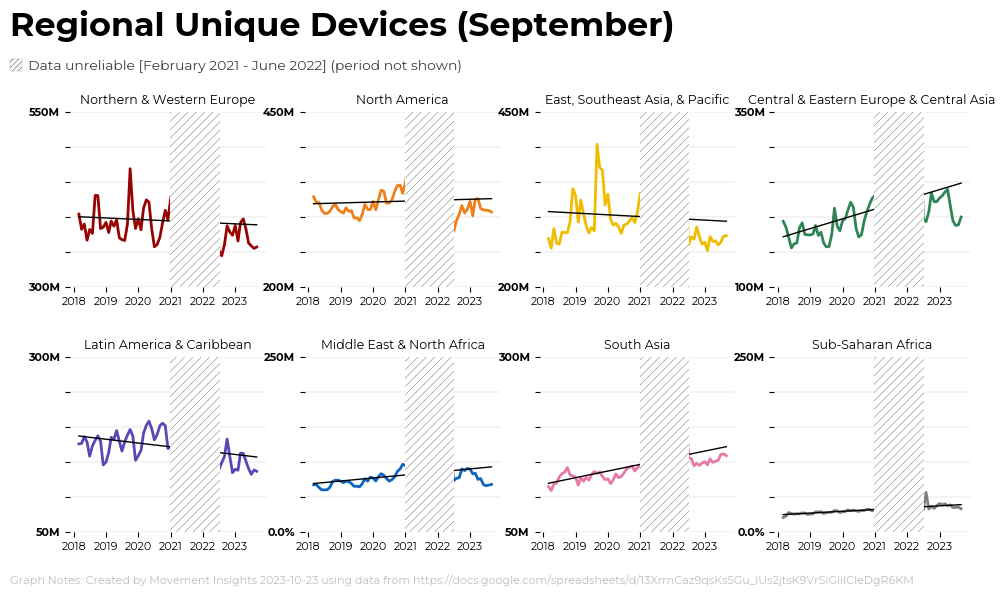

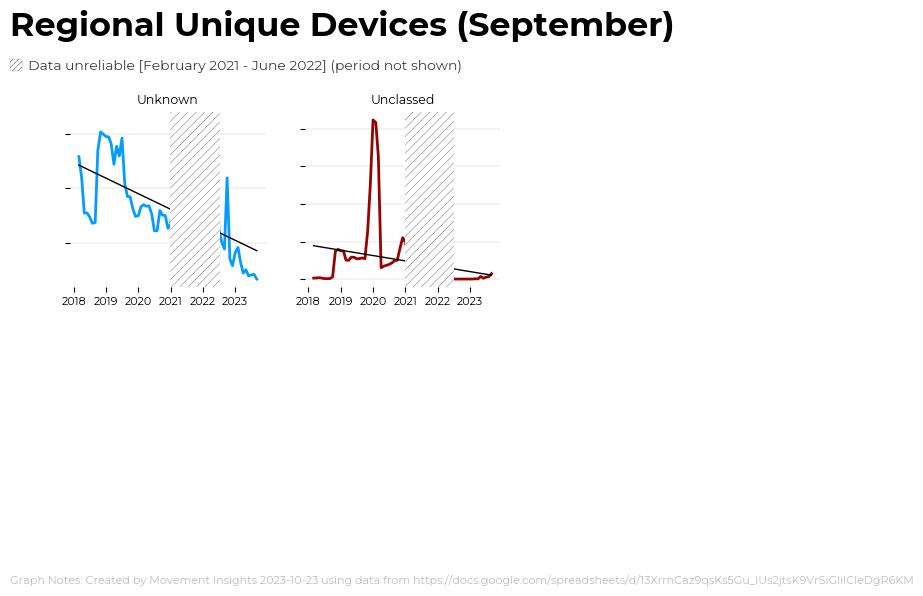

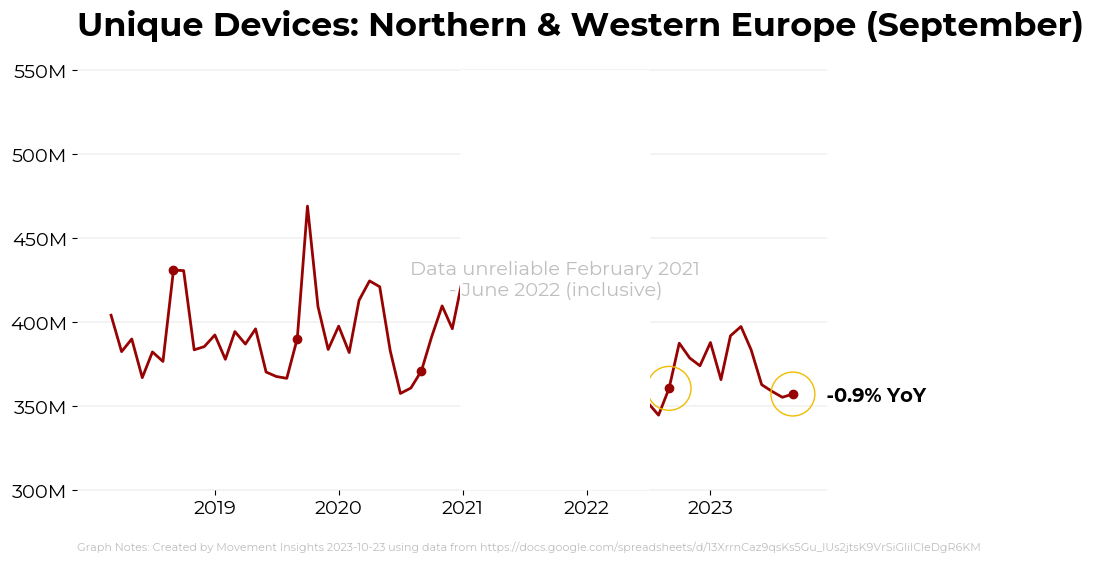

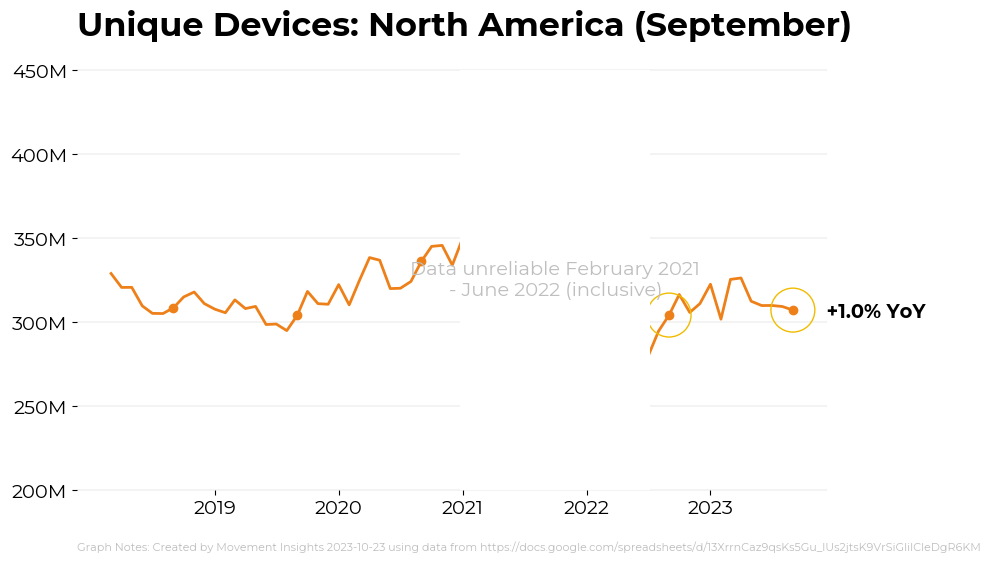

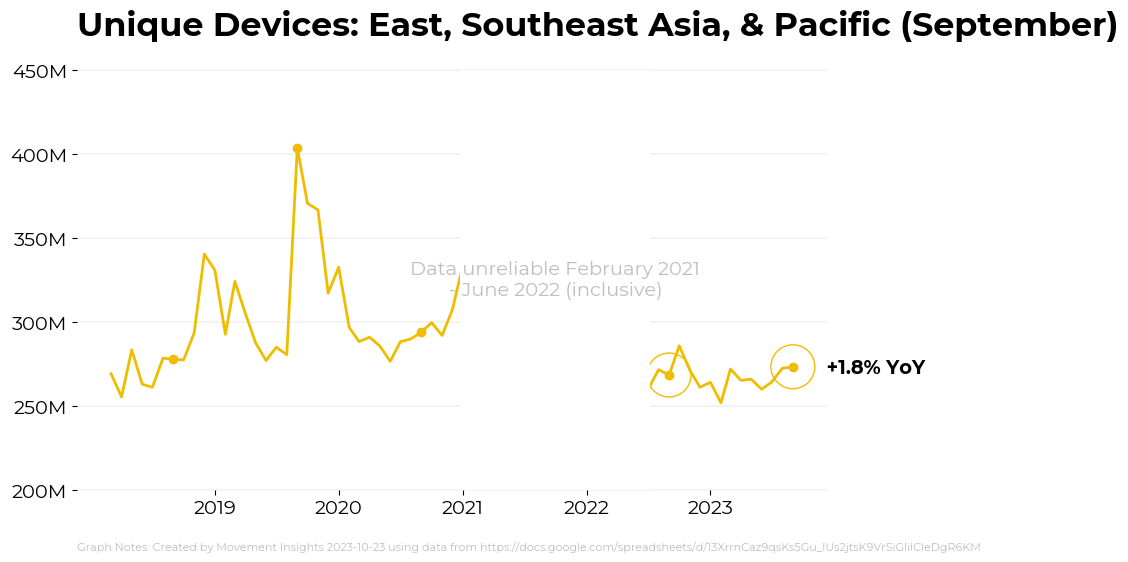

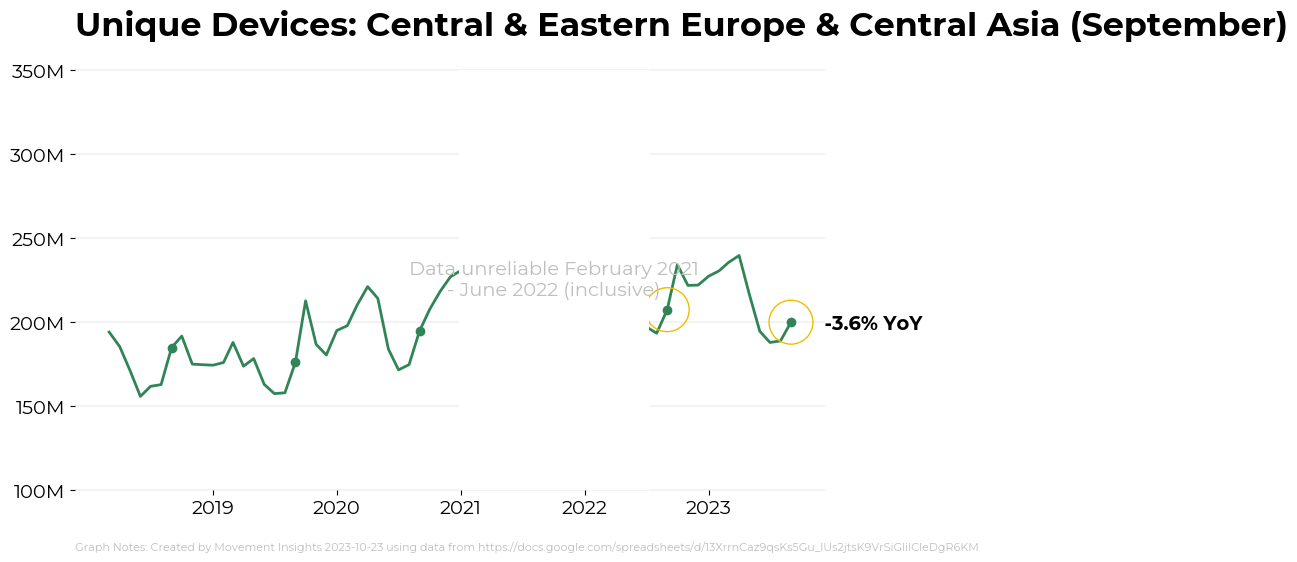

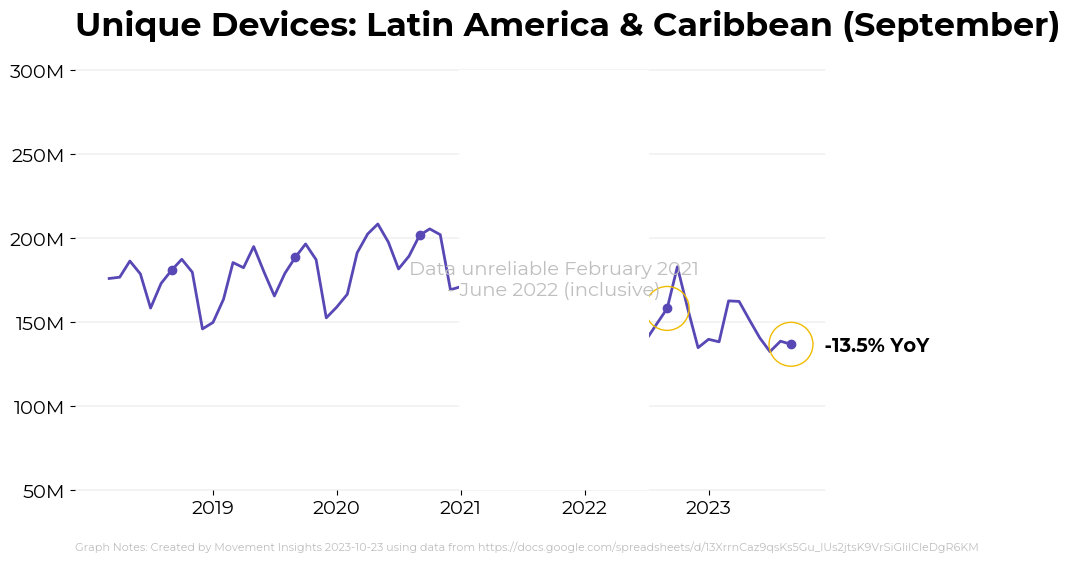

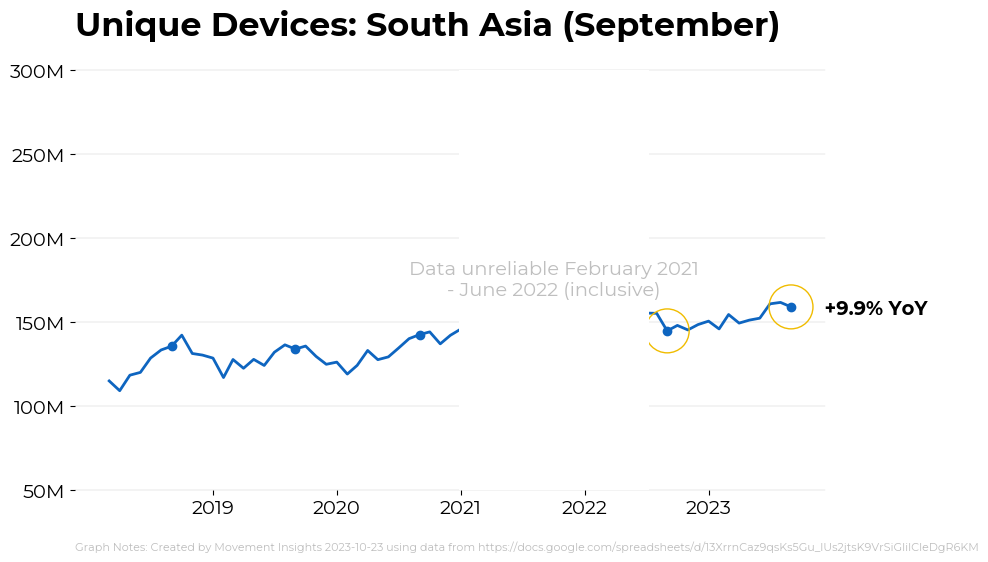

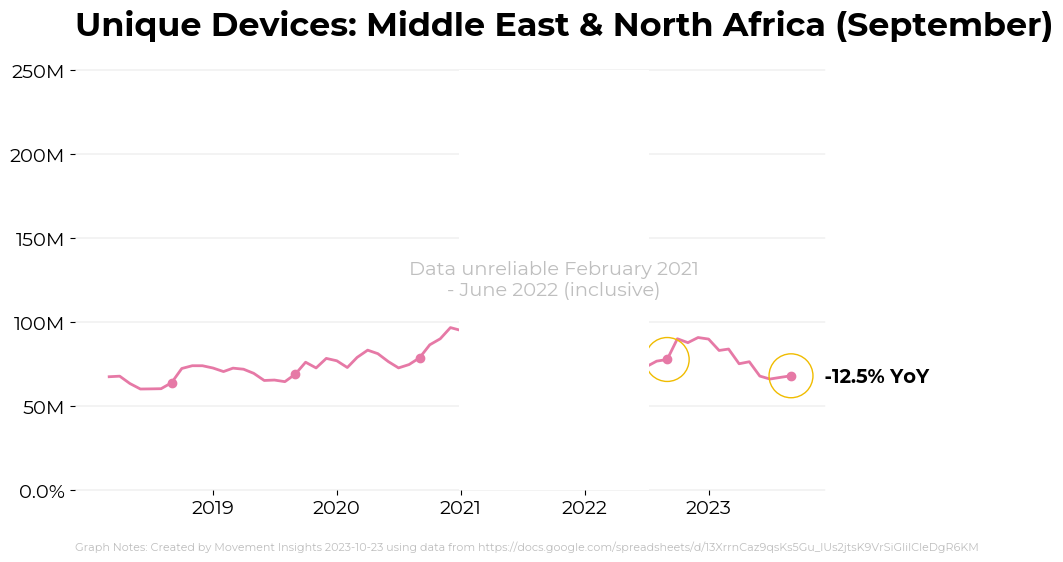

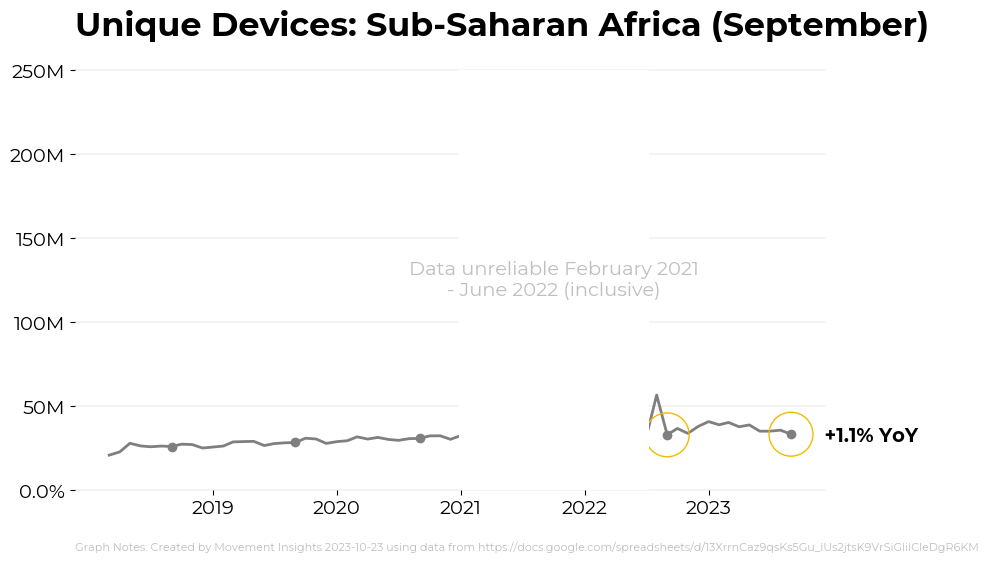

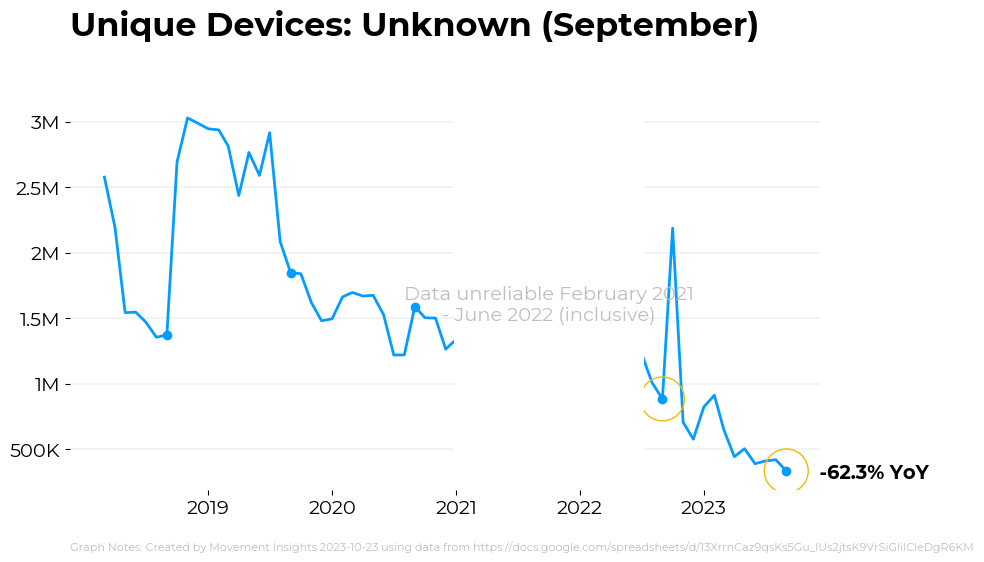

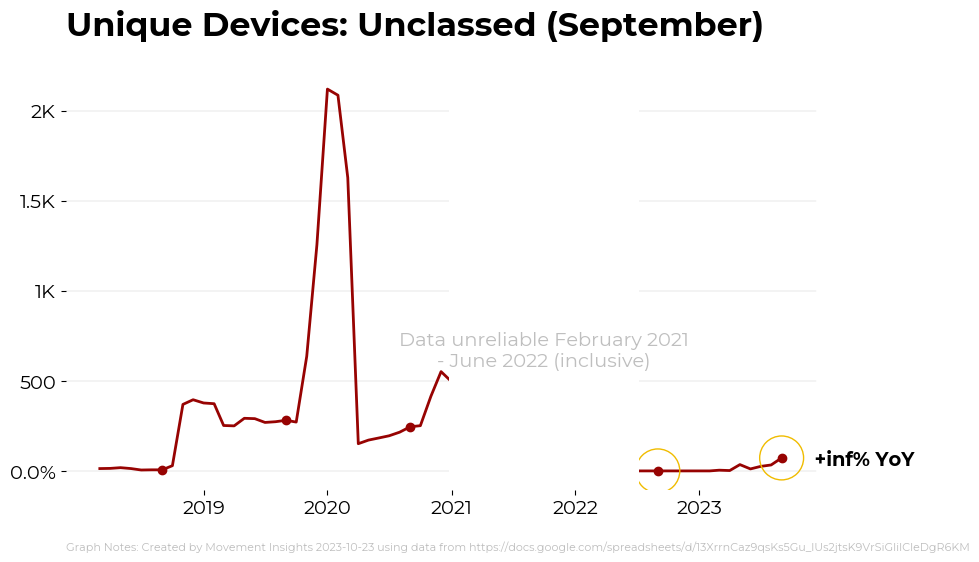

Generating Active Editors chart...
 


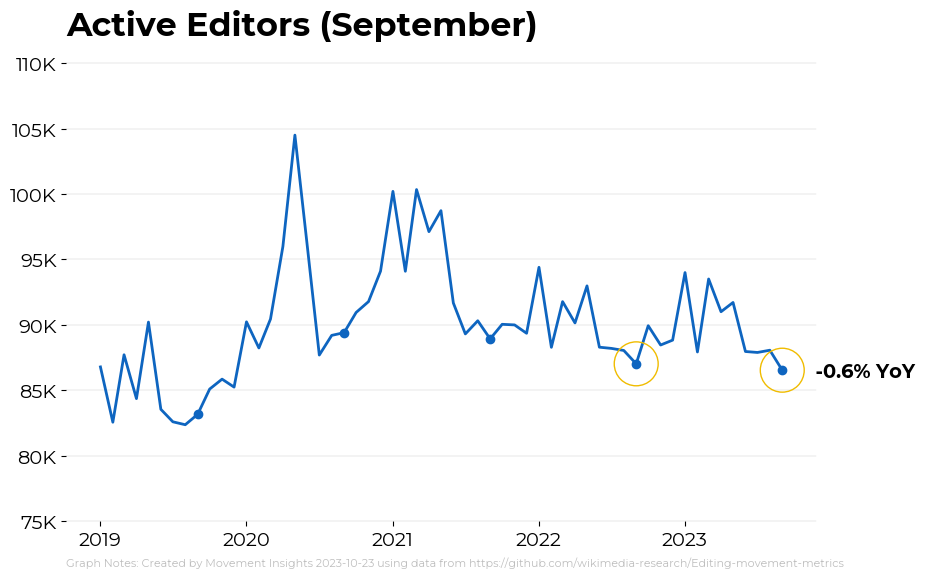

Generating New Returning chart...




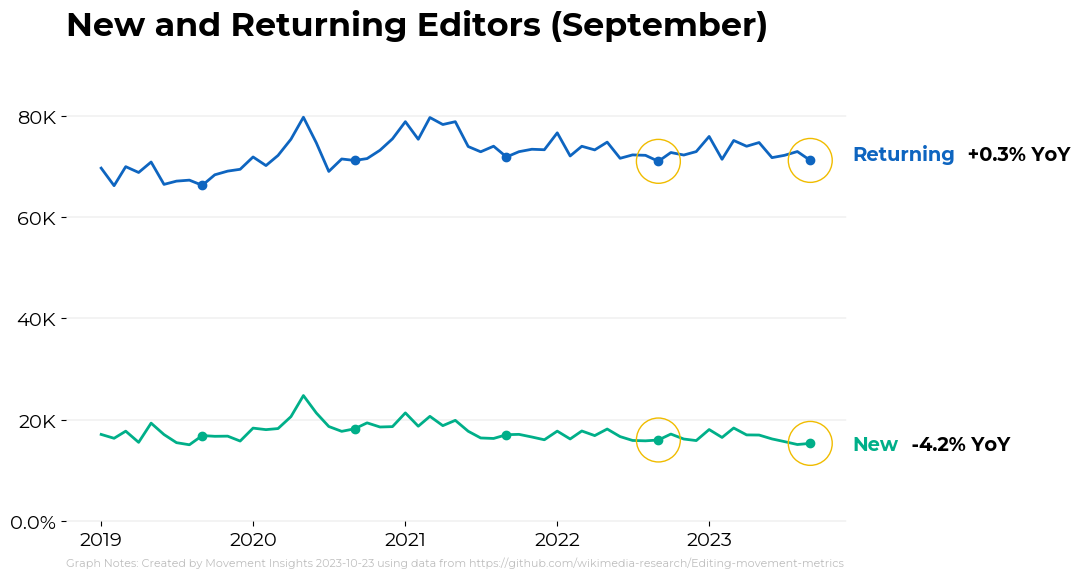

Generating Net New Content chart...





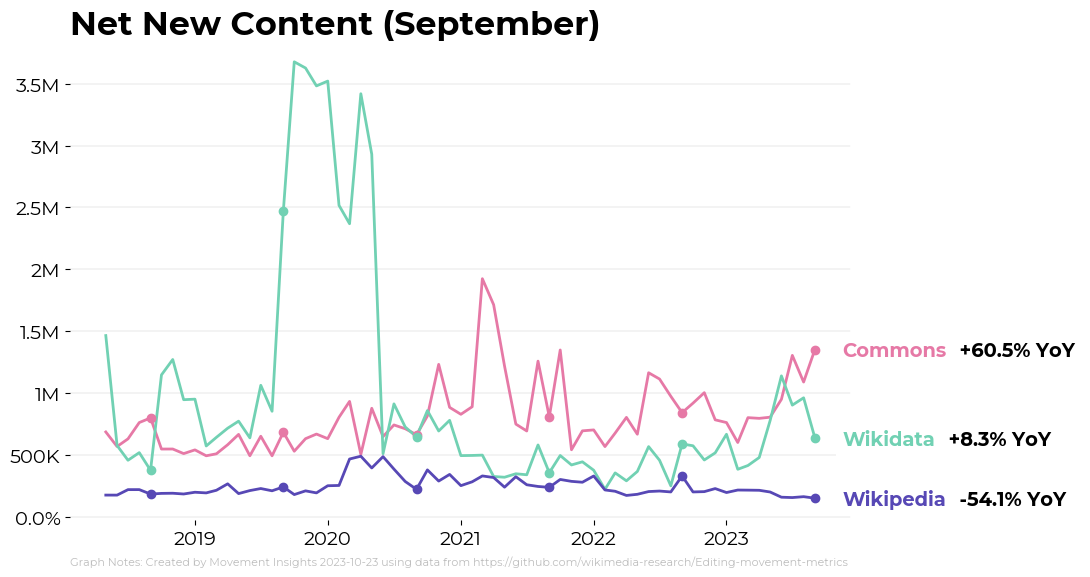

Generating region chart..


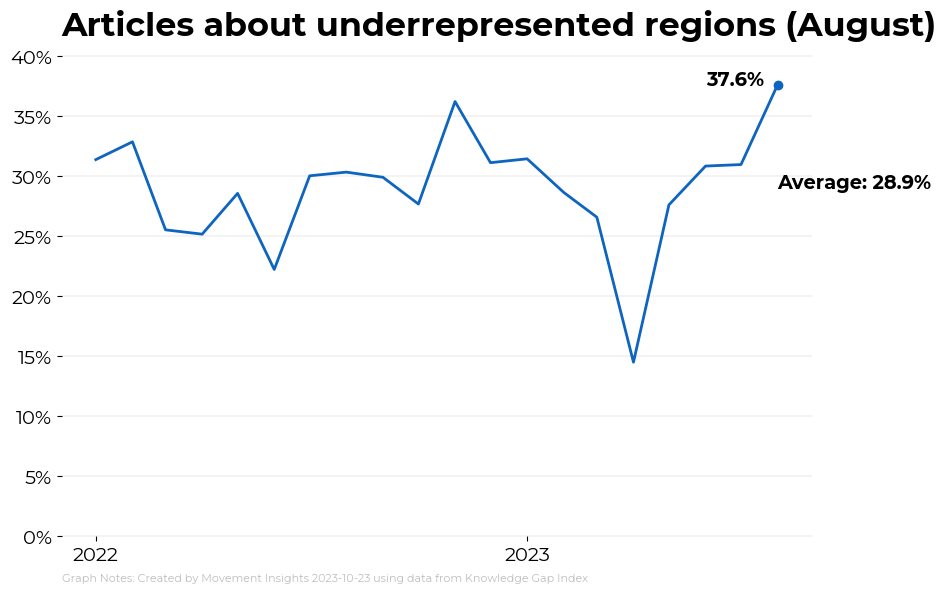

Generating Women % Distribution chart...


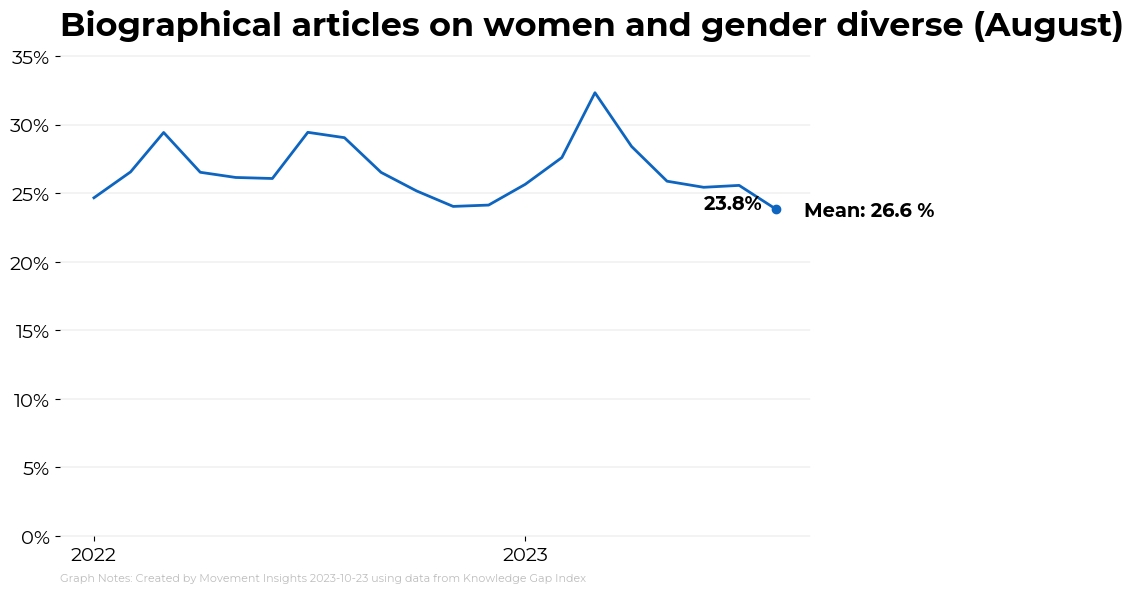

Resetting directory to:/srv/home/hghani/movement-metrics/wikicharts


In [6]:
%run "wikicharts/CORE_AND_ESSENTIAL_METRICS.ipynb"